In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Sem 4/CV/Assignment_2'


/content/drive/MyDrive/Sem 4/CV/Assignment_2


#1. Image Mosaicing

In [ ]:
#import libraraies
import cv2
import imageio
import matplotlib.pyplot as plt
import math
import random
import numpy as np
#requirements
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17


In [ ]:
def removeBlackBoxes(img):
  for i in range(img.shape[0]-1, 0, -1):
    if (img[i] != 0).any():
      img = img[:i]
      break

  for i in range(img.shape[1]-1, 0, -1):
    if (img[:, i] != 0).any():
      img = img[:, :i]
      break

  for i in range(0, img.shape[1]):
    if (img[:, i] != 0).any():
      img = img[:, i:]
      break
      
  for i in range(0, img.shape[0]):
    if (img[i] != 0).any():
      img = img[i:]
      break
      
  return img

def getHomographyMatrix(ptsA, ptsB):
    mat = []
    ptsA = np.concatenate((ptsA, np.ones((ptsA.shape[0], 1))), axis=1)
    ptsB = np.concatenate((ptsB, np.ones((ptsB.shape[0], 1))), axis=1)

    for i in range(len(ptsA)):
      p1 = ptsA[i]
      p2 = ptsB[i]
      a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0, p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
      a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
      mat.append(a1)
      mat.append(a2)

    mat = np.matrix(mat)
    #svd composition
    u, s, v = np.linalg.svd(mat)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize
    h = (1/h.item(8)) * h

    return h

def getReconstructionError(ptsA, ptsB, H):
  ptsA = np.concatenate((ptsA, np.ones((ptsA.shape[0], 1))), axis=1)
  ptsB = np.concatenate((ptsB, np.ones((ptsB.shape[0], 1))), axis=1)
  res = ptsA.dot(H.T)
  res = np.divide(res, res[:, 2].reshape(-1, 1))
  err = np.linalg.norm(res - ptsB, axis=1)
  return  np.count_nonzero( err < 10 )

def ransacHomography(ptsA, ptsB):
  err_min = 0
  final_proj_mat = None
  no_iteration = 50000
  for i in range(no_iteration):
    index = random.sample(range(0, len(ptsA)), 4)
    rptsA = np.array([ptsA[i] for i in index])
    rptsB = np.array([ptsB[i] for i in index])
    proj_mat = getHomographyMatrix(rptsA, rptsB)
    recon_err = getReconstructionError(ptsA,ptsB, proj_mat)
    if recon_err > err_min:
      err_min = recon_err
      final_proj_mat = proj_mat

  # print('Reconstruction Error : ', err_min)
  return final_proj_mat

def mergeImage(img1, img2):

  sift = cv2.xfeatures2d.SIFT_create(200)
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

  bf = cv2.BFMatcher()
  matches = bf.match(descriptors_1,descriptors_2)
  matches = sorted(matches, key = lambda x:x.distance)

  img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:500], img2, flags=2)
  plt.figure(figsize=(12,12))
  plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

  kpsA = np.float32([kp.pt for kp in keypoints_1])
  kpsB = np.float32([kp.pt for kp in keypoints_2])
  # construct the two sets of points

  ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
  ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

  # estimate the homography between the sets of points
  # (H, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 4)
  H = ransacHomography(ptsB, ptsA)
  
  
  width = img2.shape[1] + img1.shape[1]
  height = img2.shape[0] + img1.shape[0]

  result = cv2.warpPerspective(img2, H, (width, height))
  resultcopy = result.copy()
  result[0:img1.shape[0], 0:img1.shape[1]] = img1
  ii,jj,kk = img1.shape
  for i in range(ii,0,-1):
    fg = False
    for j in range(jj,0,-1):
      if result[i][j][0] == 0 and result[i][j][1] == 0 and result[i][j][2] == 0:
        result[i][j] = resultcopy[i][j]
    
    if fg:
      break
  
  return removeBlackBoxes(result)



In [ ]:
def findSimilarity(img1, img2):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  descriptor_matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
  result = []
  for i, j in descriptor_matches:
      if((i.distance) < 0.6* j.distance):
        result.append(i)

  return len(result)

def multipleImageMerge(images):

  processed = [images[0]]
  images = images[1:]
  while (len(images) > 0):
    maxdist = 0
    pindex = 0
    iindex = 0
    for i in range(len(processed)):
      for j in range(len(images)):
      
        proc = processed[i]
        img = images[j]
        dis = findSimilarity(proc, img)
        
        if dis > maxdist:
          maxdist = dis
          pindex = i
          iindex = j
    result = mergeImage(processed[0],images[iindex])
    plt.figure(figsize=(12,12))
    # plt.imshow((result))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    processed = [result]
    images.pop(iindex)
    

In [ ]:
images = []
for i in range(1,7):
  images.append(cv2.imread('images/Image Mosaicing/2_' + str(i) +'.png'))
multipleImageMerge(images)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


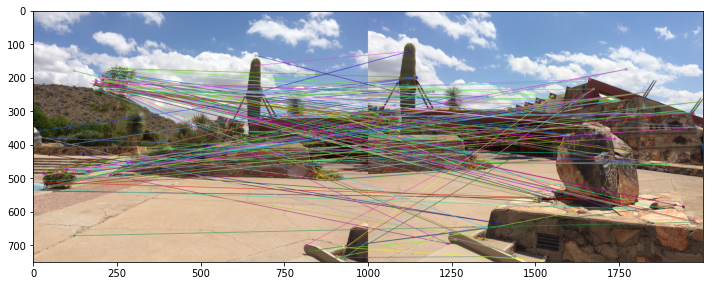

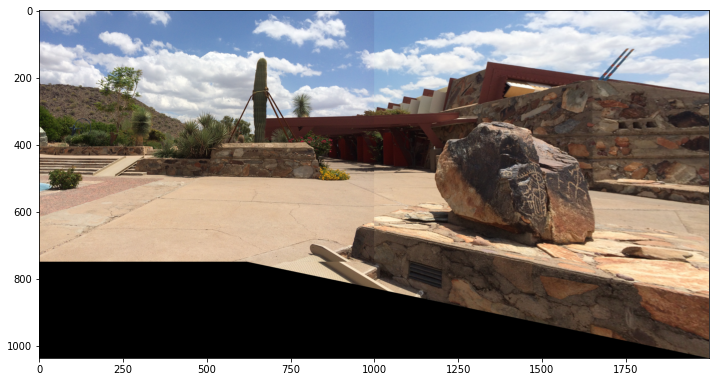

In [ ]:
images = []
for i in range(1,3):
  images.append(cv2.imread('images/Image Mosaicing/3_' + str(i) +'.png'))
multipleImageMerge(images)

In [ ]:
images = []
for i in range(1,5):
  img = (cv2.imread('images/Image Mosaicing/5_' + str(i) +'.jpg'))
  img = cv2.resize(img,(0,0),fx=0.2,fy=0.2)
  images.append(img)

multipleImageMerge(images)


Output hidden; open in https://colab.research.google.com to view.

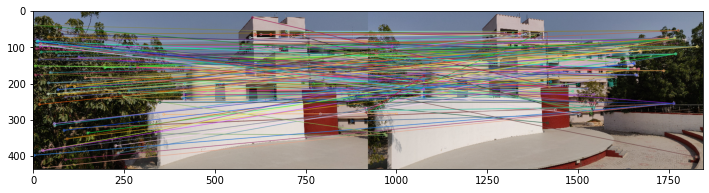

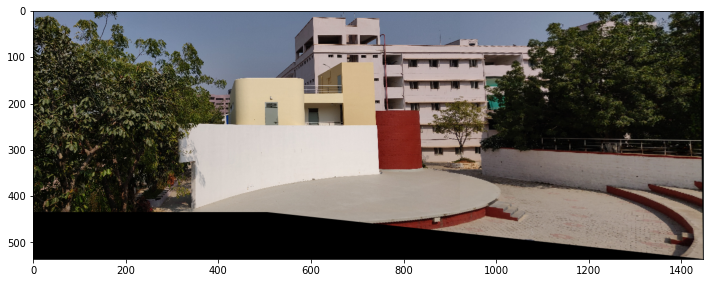

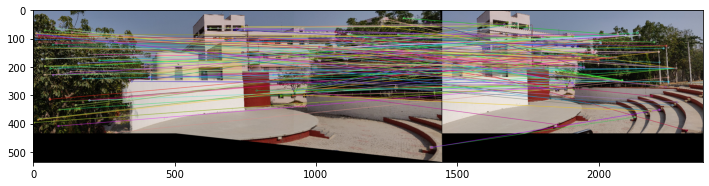

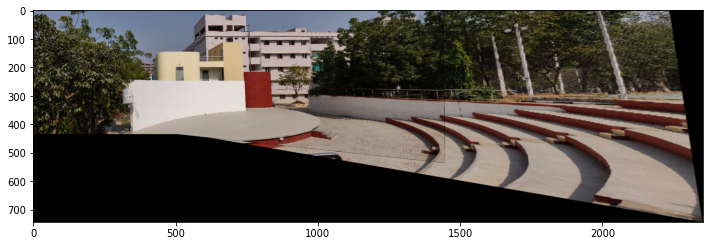

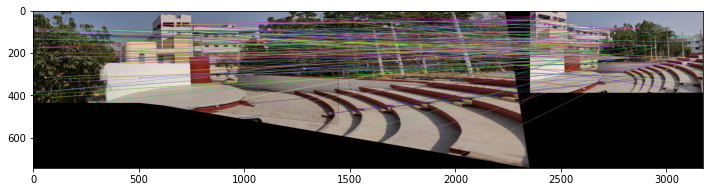

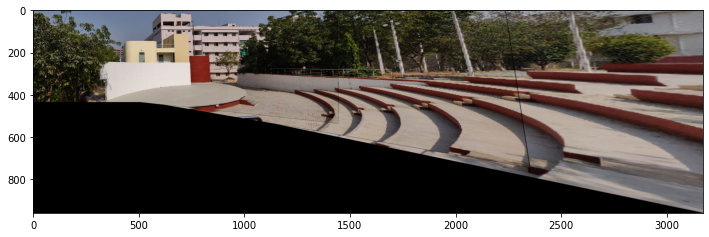

In [ ]:
images = []
for i in range(1,5):
  img = (cv2.imread('images/Image Mosaicing/1_' + str(i) +'.jpg'))
  img = cv2.resize(img,(0,0),fx=0.2,fy=0.2)
  images.append(img)

multipleImageMerge(images)

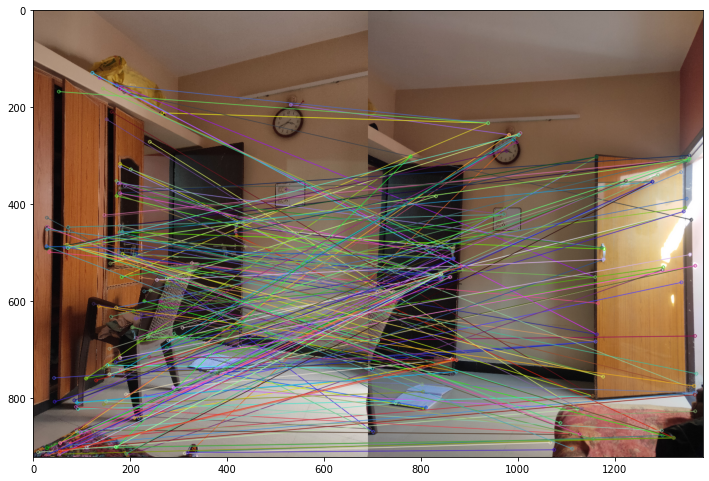

In [ ]:
images = []
for i in range(1,3):
  img = (cv2.imread('images/Image Mosaicing/7_' + str(i) +'.jpg'))
  img = cv2.resize(img,(0,0),fx=0.2,fy=0.2)
  images.append(img)

multipleImageMerge(images)

#2. Stereo Correspondences

##Intensity window-based correlation

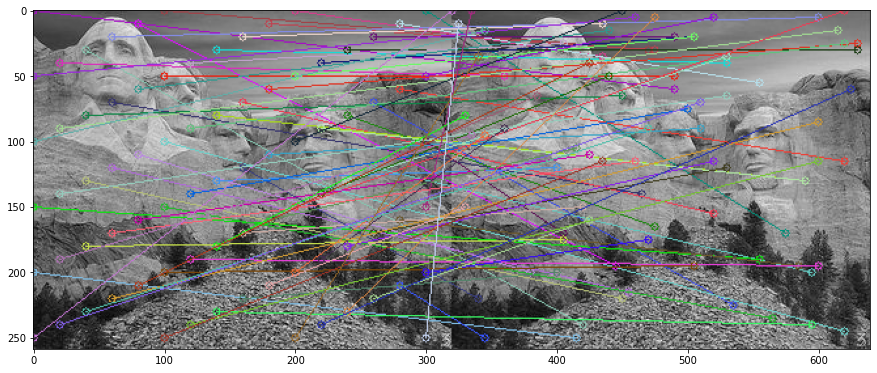

In [ ]:
def findCorrelation(v1, v2):
  v1 = v1 - np.average(v1)
  v2 = v2 - np.average(v2)
  nume = np.sum(np.multiply(v1,v2))
  deno = math.sqrt(np.sum(np.multiply(v1,v1)))
  deno *= math.sqrt(np.sum(np.multiply(v2,v2)))
  return nume/deno

def findBestMatch(win1, img2, winsize):
  bestmatch = [None,None,None]
  mindist = 2

  for i in range(0, img2.shape[0]-winsize,5):
    for j in range(0, img2.shape[1]-winsize,5):
      win2 = img2[i:i+winsize-1,j:j+winsize-1]
      dist = findCorrelation(win1.flatten(),win2.flatten())
      if dist < mindist:
        mindist = dist
        bestmatch = [i,j, mindist]

  return bestmatch
  

def drawMatching(kpts1, kpts2,img1,img2):
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    image = np.concatenate((img1, img2), axis=1)
    temp = int(image.shape[1]/2)

    for i in range(0,len(kpts1),10):
      color = tuple(random.sample(range(0, 255), 3))
      cv2.circle(image,tuple(kpts1[i]),3,color)
      cv2.circle(image,tuple([kpts2[i][0]+temp,kpts2[i][1]]),3,color)
      cv2.line(image,tuple(kpts1[i]), tuple([kpts2[i][0]+temp,kpts2[i][1]]), color,1)

    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()

def intensityWindowCorrelation(img1, img2):

  winsize = 5
  img1 = np.array(img1)
  kpts1 = []
  kpts2 = []
  matches = []
  k = 0
  for i in range(0, img1.shape[0]-winsize,10):
    for j in range(0, img1.shape[1]-winsize,10):
      win1 = img1[i:i+winsize-1,j:j+winsize-1]
      k,l,mindist = findBestMatch(win1,img2, winsize)
      if mindist == None:
        continue
      kp1 = (j,i)
      kp2 = (l,k)
      kpts1.append(kp1)
      kpts2.append(kp2)
      matches.append(cv2.DMatch(k,k,mindist))
      k += 1 

  drawMatching(kpts1,kpts2,img1,img2)


img1 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/1_1.jpg',0)  
img2 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/1_2.jpg',0) 

intensityWindowCorrelation(img1,img2)

##Epipolar lines

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def epipolarLines(img1, img2):
  sift = cv2.xfeatures2d.SIFT_create()

  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)

  # FLANN parameters
  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)

  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(des1,des2,k=2)

  good = []
  pts1 = []
  pts2 = []

  # ratio test as per Lowe's paper
  for i,(m,n) in enumerate(matches):
      if m.distance < 0.8*n.distance:
          good.append(m)
          pts2.append(kp2[m.trainIdx].pt)
          pts1.append(kp1[m.queryIdx].pt)
  pts1 = np.int32(pts1)
  pts2 = np.int32(pts2)
  F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

  # We select only inlier points
  pts1 = pts1[mask.ravel()==1]
  pts2 = pts2[mask.ravel()==1]

  lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines(img1,img2,lines1[:20],pts1[:20],pts2[:20])

  lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines(img2,img1,lines2[:20],pts2[:20],pts1[:20])
  plt.figure(figsize=(12,12))
  plt.subplot(121),plt.imshow(img5)
  plt.subplot(122),plt.imshow(img3)
  plt.show()

  return pts1,pts2,F

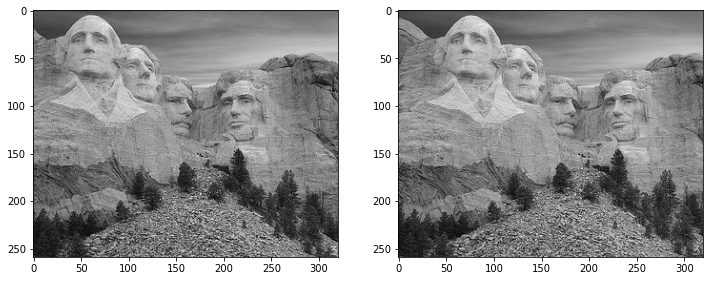

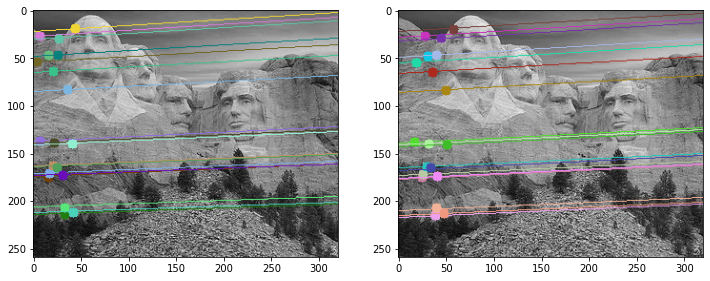

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/1_1.jpg',0)  #queryimage # left image
img2 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/1_2.jpg',0) #trainimage # right image
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1, cmap='gray')
plt.subplot(122),plt.imshow(img2, cmap='gray')
plt.show()
pts1,pts2,F = epipolarLines(img1,img2)


##Stereo Rectification

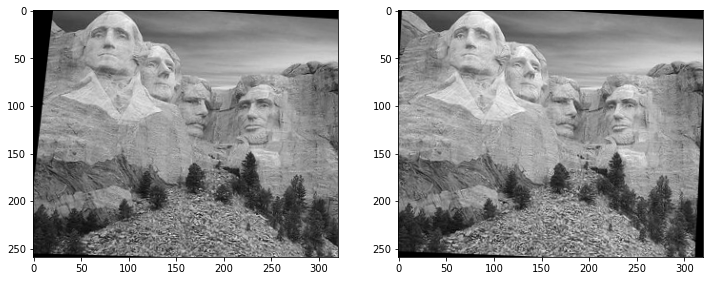

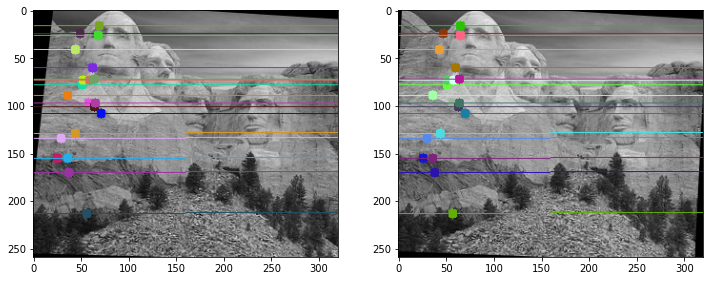

In [ ]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1_rectified,cmap='gray')
plt.subplot(122),plt.imshow(img2_rectified, cmap='gray')
plt.show()
pts1,pts2,F = epipolarLines(img1_rectified,img2_rectified)


##Greedy Solution for Stereo Correspodence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


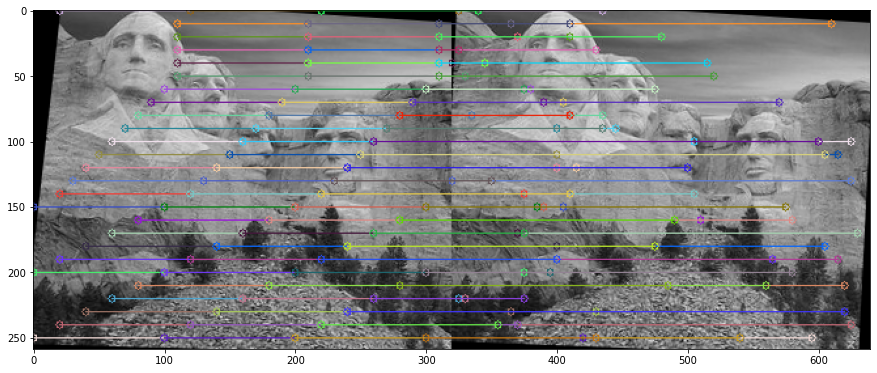

In [ ]:

def drawMatching(kpts1, kpts2,img1,img2):
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    image = np.concatenate((img1, img2), axis=1)
    image = cv2.hconcat([img1, img2])
    temp = int(image.shape[1]/2)

    for i in range(0,len(kpts1),10):
      color = tuple(random.sample(range(0, 255), 3))
      cv2.circle(image,tuple(kpts1[i]),3,color)
      cv2.circle(image,tuple([kpts2[i][0]+temp,kpts2[i][1]]),3,color)
      cv2.line(image,tuple(kpts1[i]), tuple([kpts2[i][0]+temp,kpts2[i][1]]), color,1)

    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()

def findBestMatchInSameRow(win1,img2, winsize, i):
  bestmatch = [None,None,None]
  mindist = 2

  for j in range(0, img2.shape[1]-winsize,5):
    win2 = img2[i:i+winsize-1,j:j+winsize-1]
    dist = findCorrelation(win1.flatten(),win2.flatten())
   
    if dist < mindist:
      mindist = dist
      bestmatch = [j,i, mindist]

  return bestmatch

def greedyMatching(img1,img2):

  winsize = 5
  img1 = np.array(img1)
  kpts1 = []
  kpts2 = []

  for i in range(0, img1.shape[0]-winsize,10):
    for j in range(0, img1.shape[1]-winsize,10):
     
      win1 = img1[i:i+winsize-1,j:j+winsize-1]   
      k,l,mindist = findBestMatchInSameRow(win1,img2, winsize, i)
      color = tuple(random.sample(range(0, 255), 3))
      
      if mindist == None:
        continue
  
      kp1 = (j,i)
      kp2 = (k,l)
      kpts1.append(kp1)
      kpts2.append(kp2)
  drawMatching(kpts1,kpts2,img1,img2)

greedyMatching(img1_rectified,img2_rectified)

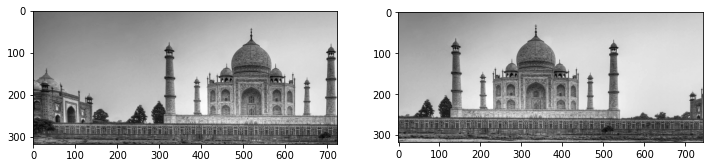

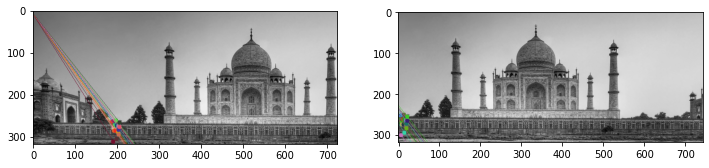

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/2_1.png',0)  #queryimage # left image
img2 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/2_2.png',0) #trainimage # right image

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1, cmap='gray')
plt.subplot(122),plt.imshow(img2, cmap='gray')
plt.show()
pts1,pts2,F = epipolarLines(img1,img2)

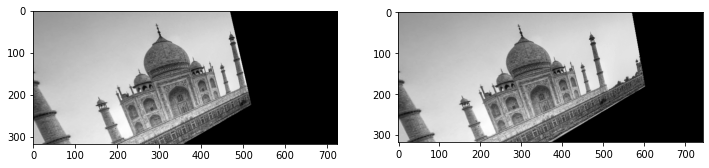

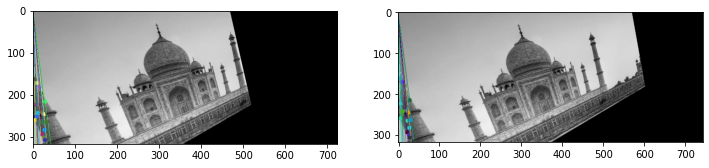

In [ ]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1_rectified,cmap='gray')
plt.subplot(122),plt.imshow(img2_rectified, cmap='gray')
plt.show()
pts1,pts2,F = epipolarLines(img1_rectified,img2_rectified)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


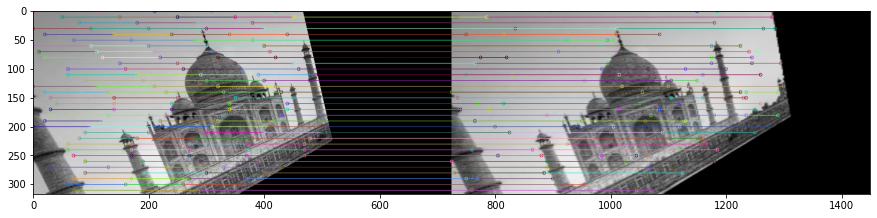

In [ ]:
img2_rectified = cv2.resize(img2_rectified, (725,317))
greedyMatching(img1_rectified,img2_rectified)

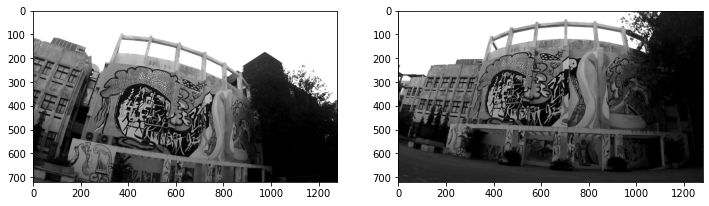

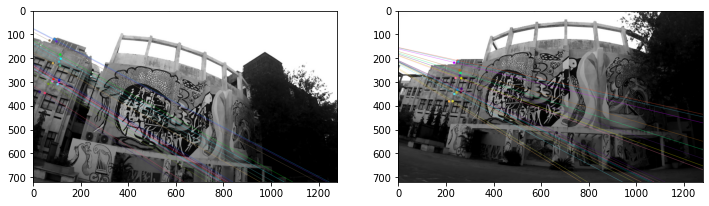

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/3_1.jpg',0)  #queryimage # left image
img2 = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_2/images/Stereo Correspondence/3_2.jpg',0) #trainimage # right image

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1, cmap='gray')
plt.subplot(122),plt.imshow(img2, cmap='gray')
plt.show()
pts1,pts2,F = epipolarLines(img1,img2)

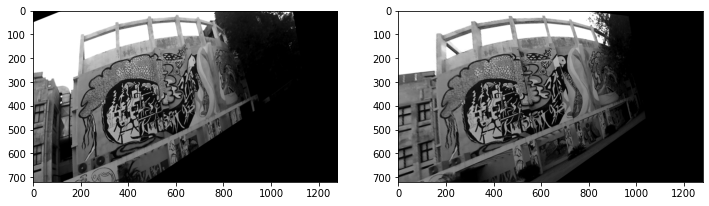

In [ ]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(img1_rectified,cmap='gray')
plt.subplot(122),plt.imshow(img2_rectified, cmap='gray')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


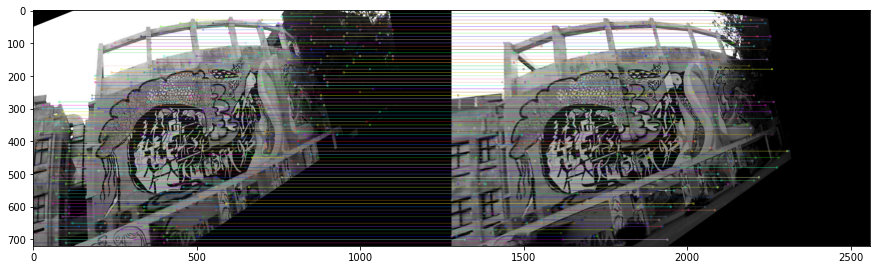

In [ ]:
greedyMatching(img1_rectified,img2_rectified)